In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import shap

In [2]:
#loading the stopwords library and the nltk to be used for the text preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re



def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens) #--- Joins the token into a simple word. 

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data['processed_review'].head()

0           side effect take combin bystol mg fish oil
1    son halfway fourth week intuniv becam concern ...
2    use take anoth oral contracept pill cycl happi...
3    first time use form birth control im glad went...
4    suboxon complet turn life around feel healthie...
Name: processed_review, dtype: object

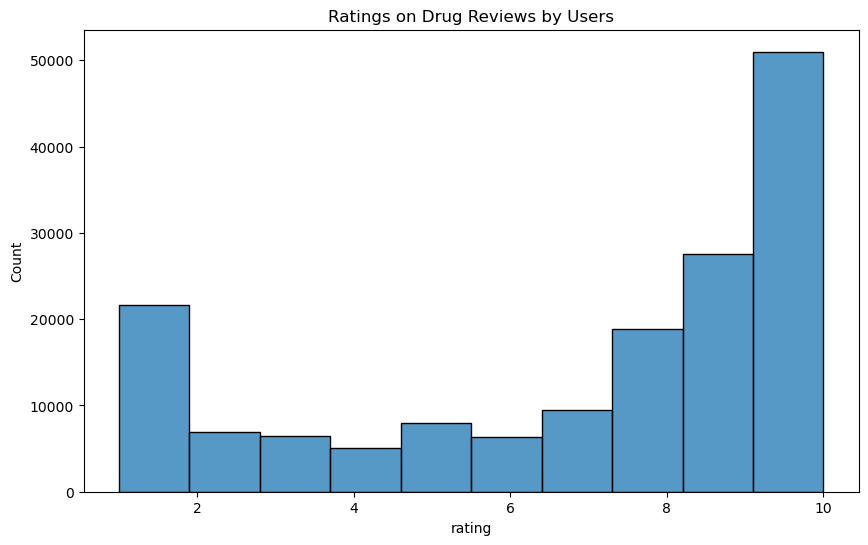

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Ratings on Drug Reviews by Users')
plt.savefig('histogram_of_ratings.png')
plt.show()

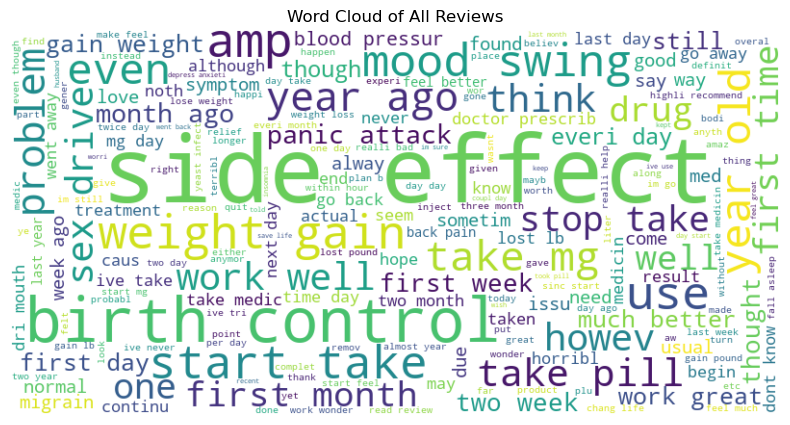

In [6]:
#creating a word cloud to visualize the most used words in 215,063 drug reviews by the users
from wordcloud import WordCloud

all_words = ' '.join(train_data['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Word Cloud of All Reviews')

plt.savefig('wordcloud.png')
plt.show()

In [7]:
#---------TF-IDF -----------#

#Now in this stage we want to assign importance to words in the training data by using the TF IDF method which 
#can help distinguish words in accordance to how they are most used for ratings

#tfidf = TfidfVectorizer(max_features=5000)
#X_tfidf = tfidf.fit_transform(train_data['processed_review'])
#y = train_data['rating']
#X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)



## Text Processing and Feature Engineering

In [9]:
import gensim


# Training a Word2Vec model tokenized reviews using the SkipGram method
word2vec_model = gensim.models.Word2Vec(sentences=train_data['processed_review'], vector_size=300, window=5, min_count=2, sg=1, workers=4)


def get_average_word2vec(tokens_list, model, vector_size):
    
    valid_words = [word for word in tokens_list if word in model.wv.key_to_index] #vocabulary from word2Vec model
    
    if not valid_words: 
        return np.zeros(vector_size) #we want to return a zero vector for the doc in case no valid words are found in the doc
    
    return np.mean(model.wv[valid_words], axis=0) # the entire review is converted into a single vector, 
                                                  #instead of different vectors for each word in the document

vector_size = word2vec_model.vector_size
train_data['word2vec_review'] = train_data['processed_review'].apply(lambda x: get_average_word2vec(x, word2vec_model, vector_size))


X_word2vec = np.vstack(train_data['word2vec_review'].values) # To convert the into a numpy array

y = train_data['rating']

X_train_w2v, X_val_w2v, y_train, y_val = train_test_split(X_word2vec, y, test_size=0.2, random_state= 16 )



In [10]:
X_train_w2v.shape #This Word2Vec now has an array of 129037 docs with 300 features from the the word2Vec model 

(129037, 300)

In [11]:
'''
By averaging the word vectors from Word2Vec, the entire review in a doc has been converted into a single vector. \n
There's no sequence or timesteps anymore because each review is now represented as just one vector. \n
The second parameter 1 is added to represent a dummy timestep—a sequence of length 1 as LSTM requires a 3D data to process
''' 

X_train_w2v = np.reshape(X_train_w2v, (X_train_w2v.shape[0], 1, X_train_w2v.shape[1]))
X_val_w2v = np.reshape(X_val_w2v, (X_val_w2v.shape[0], 1, X_val_w2v.shape[1]))

X_train_w2v.shape

(129037, 1, 300)

In [12]:
# Because the ratings is continuous it is now normalized to be between 0 and 1
max_rating = max(np.max(y_train), np.max(y_val))
y_train_normalized = y_train / max_rating
y_val_normalized = y_val / max_rating

## Model Building